In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import numpy as np
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')

In [2]:
from LSSutils.lab import EbossCatalog
from LSSutils.extrn.spherematch import spherematch

In [3]:
dr16 = ft.read('/home/mehdi/data/eboss/data/DR16Q_v3.fits')
#fullngc = ft.read('/home/mehdi/data/eboss/data/v7_2/eBOSS_QSO_full_NGC_v7_2.dat.fits')
fullngc = ft.read('/home/mehdi/data/eboss/data/v7_2/eBOSS_QSO_full_ALL_v7_2.dat.fits')

In [4]:
m = (0.4 < fullngc['Z']) &( fullngc['Z'] < 3.8)
m &= (fullngc['COMP_BOSS'] > 0.5) & (fullngc['sector_SSR'] > 0.5)
m &= ((fullngc['IMATCH'] == 1) | (fullngc['IMATCH'] == 2))
#m.sum()
fullngc = fullngc[m]

'''
In current catalog code, sphere-match is used for legacy objects, which have IMATCH=2 in the full files. 
THING_ID is used for eboss observations, which have IMATCH=1
'''

In [5]:
legacy = fullngc[fullngc['IMATCH'] == 2]
others = fullngc[fullngc['IMATCH'] == 1]

In [6]:
legacy.size, others.size, legacy.size+others.size

(128007, 322097, 450104)

In [7]:
# 1 deg = 3600 arcsec
id_legacy, id_dr16, dis = spherematch(legacy['RA'], legacy['DEC'], 
                                      dr16['RA'], dr16['DEC'], tol=2./3600.)

In [8]:
# NGC only: (88889, 88914)
id_legacy.size, legacy.size

(127981, 128007)

In [9]:
legacy_not_in_dr16 = np.setdiff1d(np.arange(legacy.size), id_legacy)

In [10]:
# ngc only: 0.9997188294306858
1 - legacy_not_in_dr16.size / legacy.size

0.9997968861077909

In [11]:
legacy_match = legacy[id_legacy]
legacy_zlya = dr16[id_dr16]['Z_LYAWG'].astype('f8')

In [12]:
legacy_match.size

127981

In [13]:
legacy_match['RA'][:5], dr16[id_dr16]['RA'][:5]

(array([ 25.57760734, 126.25211624, 114.68553182, 116.47152209,
        150.52726992]),
 array([ 25.577613, 126.25215 , 114.68554 , 116.471534, 150.527265]))

In [14]:
# ngc only: 165
np.setdiff1d(others['THING_ID'], dr16['THING_ID']).size

238

In [15]:
z_lyawg = {}
for i in range(dr16.size):
    z_lyawg[dr16['THING_ID'][i]] = dr16['Z_LYAWG'][i]
    
other_z_lyawg = []
num = 0
for idx in others['THING_ID']:
    if idx not in z_lyawg:
        other_z_lyawg.append(-1)
        num += 1
    else:
        other_z_lyawg.append(z_lyawg[idx])    

In [16]:
other_z_lyawg = np.array(other_z_lyawg)

In [17]:
num

238

Text(0, 0.5, 'Z LYAWG [from DR16]')

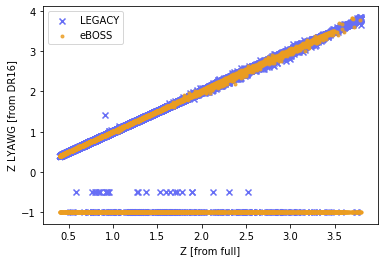

In [18]:
plt.scatter(legacy_match['Z'], legacy_zlya,
            marker='x', label='LEGACY', c='#676ef5')
plt.scatter(legacy['Z'][legacy_not_in_dr16], -0.5*np.ones(legacy_not_in_dr16.size), 
            marker='x', c='#676ef5')

plt.scatter(others['Z'], other_z_lyawg,
            c='#eb9d21', alpha=0.8, marker='.', label='eBOSS')

plt.legend()
plt.xlabel('Z [from full]')
plt.ylabel('Z LYAWG [from DR16]')

In [19]:
others_good = (other_z_lyawg != -1)
legacy_good = (legacy_zlya != -1) & (abs(legacy_zlya - legacy_match['Z']) < 0.4)

In [17]:
# ngc: (0.9924898580121704, 0.9984475019406226)
others_good.mean(), legacy_good.mean()

(0.9925953982806421, 0.998468522671334)

In [24]:
from scipy.stats import binned_statistic

In [36]:
def bin_plot(x, values, ax, **kw):
    y_, x_, _ = binned_statistic(x, values, bins=np.arange(0.4, 3.8, 0.1))
    ax.scatter(x, values, 1, alpha=0.2, color='grey')
    ax.plot(x_[:-1], y_, lw=2, **kw)
    return ax

[Text(0, 0.5, 'Z_LYAWG - Z'), Text(0.5, 0, 'Z')]

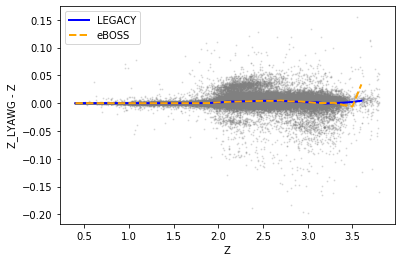

In [40]:
fig, ax = plt.subplots()

bin_plot(legacy_match['Z'][legacy_good], legacy_zlya[legacy_good]-legacy_match['Z'][legacy_good], ax, c='b', ls='-', label='LEGACY')
bin_plot(others['Z'][others_good], other_z_lyawg[others_good]-others['Z'][others_good], ax, c='orange', ls='--', label='eBOSS')
ax.legend()
ax.set(xlabel='Z', ylabel='Z_LYAWG - Z')
# ax.set_ylim(-0.6, 0.6)

In [41]:
legacy_match['Z'][legacy_good] = legacy_zlya[legacy_good]
others['Z'][others_good] = other_z_lyawg[others_good]

[Text(0, 0.5, 'Z_LYAWG - Z'), Text(0.5, 0, 'Z')]

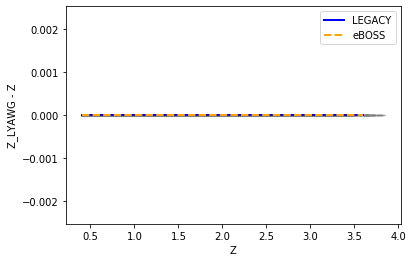

In [42]:
fig, ax = plt.subplots()

bin_plot(legacy_match['Z'][legacy_good], legacy_zlya[legacy_good]-legacy_match['Z'][legacy_good], ax, c='b', ls='-', label='LEGACY')
bin_plot(others['Z'][others_good], other_z_lyawg[others_good]-others['Z'][others_good], ax, c='orange', ls='--', label='eBOSS')
ax.legend()
ax.set(xlabel='Z', ylabel='Z_LYAWG - Z')
# ax.set_ylim(-0.6, 0.6)

In [43]:
data = np.concatenate([others[others_good], legacy_match[legacy_good]])

In [44]:
ft.write('/home/mehdi/data/eboss/data/v7_2/eBOSS_QSO_full_ALL_v7_2_zlyawg.dat.fits', data, clobber=True)

In [18]:
def get_mean_rms(z1, z2, zcut=0.):
    dz = z1 - z2
    m = (abs(dz) < 0.45) & (z2 > zcut)
    #print((~m).sum(), z1[~m], z2[~m], end=' ')
    dz = dz[m] / (1 + z2[m])
    #print(np.percentile(dz, [0, 1, 99, 100]))
    return np.mean(dz), np.sqrt(np.mean(dz*dz))

In [19]:
get_mean_rms(np.array(other_z_lyawg)[others_good], others['Z'][others_good])

(0.00010859508575219876, 0.0008642841503119957)

In [20]:
get_mean_rms(np.array(other_z_lyawg)[others_good], others['Z'][others_good], zcut=2.2)

(0.0009422687314296845, 0.002975047787315282)

In [21]:
get_mean_rms(np.array(other_z_lyawg)[others_good], others['Z'][others_good], zcut=2.2)

(0.0009422687314296845, 0.002975047787315282)

In [22]:
get_mean_rms(legacy['Z'][id_legacy][legacy_good], legacy_z_lyawg[legacy_good])

(-0.0004644188960222958, 0.002106198577023135)

In [23]:
get_mean_rms(legacy['Z'][id_legacy][legacy_good], legacy_z_lyawg[legacy_good], zcut=2.2)

(-0.0009597939212474579, 0.002934523192018473)

Text(0.5, 0, 'Z')

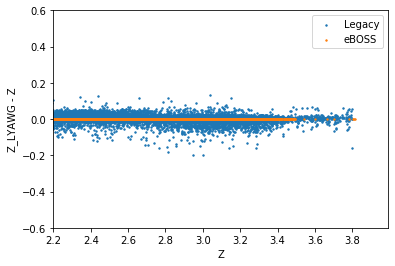

In [43]:
plt.scatter(legacy['Z'][id_legacy][legacy_good], legacy_z_lyawg[legacy_good]-legacy['Z'][id_legacy][legacy_good], 2)
plt.scatter(others['Z'][others_good], np.array(other_z_lyawg)[others_good]-others['Z'][others_good], 2)
plt.legend(['Legacy', 'eBOSS'])
plt.ylim(-0.6, 0.6)
plt.xlim(xmin=2.2)
plt.ylabel(r'Z_LYAWG - Z')
plt.xlabel('Z')

In [36]:
np.argwhere(abs(legacy['Z'][id_legacy][legacy_good] - legacy_z_lyawg[legacy_good]) > 0.4)

array([[70599]])

In [35]:
legacy_z_lyawg[legacy_good][70599] = np.nan

In [44]:
np.array(other_z_lyawg)[others_good], others['Z'][others_good]

(array([1.78929055, 1.24313903, 1.09754503, ..., 0.67134804, 1.45899796,
        1.73183107]),
 array([1.78929055, 1.24313903, 1.09754503, ..., 0.67134804, 1.45899796,
        1.73183107]))

In [49]:
legacy['Z'][id_legacy][legacy_good] = legacy_z_lyawg[legacy_good]

In [52]:
legacy['Z'][id_legacy][legacy_good], legacy_z_lyawg[legacy_good].astype('f8')

(array([1.40961342, 1.64622804, 1.87644057, ..., 2.25665314, 3.10669756,
        1.20035564]),
 array([1.40961301, 1.64622819, 1.87643552, ..., 2.25896311, 3.0951221 ,
        1.20035625]))

In [37]:
others['Z'][others_good] =  np.array(other_z_lyawg)[others_good]
legacy['Z'][id_legacy][legacy_good] = legacy_z_lyawg[legacy_good]

In [38]:
others_n = others[others_good]
legacy_n = legacy[id_legacy][legacy_good]
legacy_n.size+others_n.size, legacy.size+others.size

(447497, 450104)

In [39]:
data = np.concatenate([others_n, legacy_n])

In [40]:
ft.write('/home/mehdi/data/eboss/data/v7_2/eBOSS_QSO_full_ALL_v7_2_zlyawg.dat.fits', data)

In [42]:
data['Z']

array([1.78929055, 1.24313903, 1.09754503, ..., 2.25665314, 3.10669756,
       1.20035564])

In [25]:
legacy_good.size-legacy.size

-26

In [26]:
def add_scatter(d, **kw):
    plt.scatter(d['RA'], np.sin(np.deg2rad(d['DEC'])), 5, **kw)

Text(0, 0.5, 'sin(Dec)')

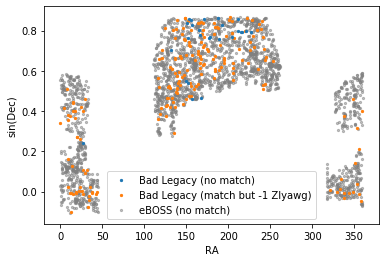

In [27]:
add_scatter(legacy[legacy_not_in_dr16], zorder=10)
add_scatter(legacy[id_legacy][~legacy_good])
add_scatter(others[~others_good], zorder=-1, color='grey', alpha=0.5)
plt.legend(['Bad Legacy (no match)', 'Bad Legacy (match but -1 Zlyawg)', 'eBOSS (no match)'])
plt.xlabel('RA')
plt.ylabel('sin(Dec)')

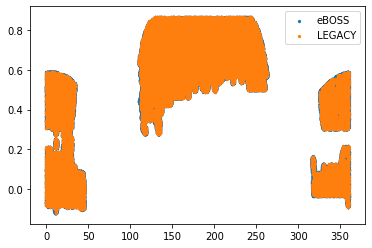

In [28]:
add_scatter(others)
add_scatter(legacy)
plt.legend(['eBOSS', 'LEGACY'])

In [25]:
from nbodykit.cosmology import Planck15
from nbodykit.lab import ArrayCatalog
from nbodykit.lab import RedshiftHistogram

In [26]:
others_cat = ArrayCatalog(others)
legacy_cat = ArrayCatalog(legacy)

In [27]:
def multiplyweights(data):
    data['Weight'] = data['WEIGHT_NOZ']*data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_SYSTOT']
    return data

In [28]:
others_cat = multiplyweights(others_cat)
legacy_cat = multiplyweights(legacy_cat)

In [29]:
nz_others = RedshiftHistogram(others_cat, 0.062, Planck15, redshift='Z', weight='Weight',
                              bins=np.linspace(0., 4.0, 50, endpoint=True))
nz_legacy = RedshiftHistogram(legacy_cat, 0.062, Planck15, redshift='Z',
                              weight='Weight', bins=np.linspace(0., 4.0, 50, endpoint=True))

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


(-0.2, 4)

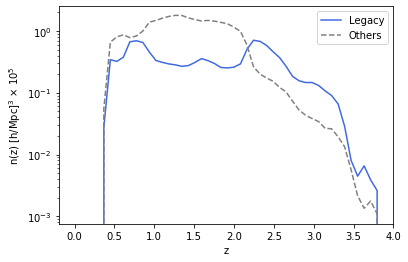

In [31]:
c = ['royalblue', 'grey']
i = 0
for (lsi,nzi) in zip(['-', '--'], [nz_legacy, nz_others]):
    plt.plot(nzi.bin_centers, 1.0e5*nzi.nbar, ls=lsi, c=c[i])
    i += 1

plt.legend(['Legacy', 'Others'])
plt.ylabel(r'n(z) [h/Mpc]$^{3}$ $\times$ 10$^{5}$')
plt.xlabel('z')
plt.yscale('log')
# plt.plot(nbar_ngc[:,0], nbar_ngc[:, 3]*1.0e5, 'k-', alpha=0.5)
plt.ylim(0, 2.5)
plt.xlim(-0.2, 4)
# plt.savefig('nz_mocks_ngc.pdf', bbox_inches='tight')

In [41]:
(~legacy_good).sum()

138

In [16]:
# nums of legacy objects that did not find a match
legacy_not_in_dr16.size

25

In [17]:
# num of legacy objs found a match, but the match has z_lyawg = -1
(legacy_z_lyawg == -1).sum()  

138

In [18]:
# num of eboss objs found a match, but the match has z_lyawg = -1
(np.array(other_z_lyawg) == -1).sum() 

1481

In [19]:
# num of eboss, # of legacy
others.size, legacy.size

(197200, 88914)

Text(0, 0.5, 'sep [arcsec]')

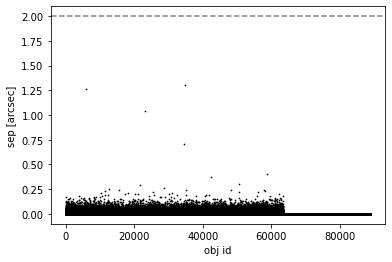

In [22]:
plt.scatter(np.arange(dis.size), dis*3600., 2, c='k', marker='.')
plt.axhline(2., ls='--', c='grey')
plt.xlabel('obj id')
plt.ylabel('sep [arcsec]')

In [14]:
id_legacy.size / legacy.size

0.9997188294306858

In [107]:
dr16['THING_ID'].min(), dr16['THING_ID'].max()

(-1, 563078069)

Text(0, 0.5, 'Z LYAWG [from DR16]')

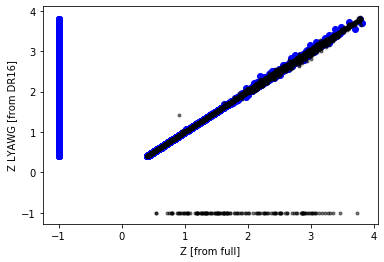

In [26]:
plt.scatter(other_z_lyawg, others['Z'], c='b', alpha=0.5)
plt.scatter(legacy['Z'][id_legacy], legacy_z_lyawg,
            c='k', marker='.', alpha=0.5)
plt.xlabel('Z [from full]')
plt.ylabel('Z LYAWG [from DR16]')

In [15]:
np.unique(dr16['THING_ID'])

array([       -1,   7095815,   7537609, ..., 563023389, 563038883,
       563078069])

In [16]:
np.unique(others['THING_ID'])

array([253043834, 253059639, 253111665, ..., 527789346, 527811397,
       527818025])

In [106]:
others_z_lyawg = []

dr16_thingid = dr16['THING_ID']
dr16_zlyawg = dr16['Z_LYAWG']

for j, oth_id in enumerate(others['THING_ID']):
    
    inx = np.argwhere(dr16_thingid == oth_id).flatten()
    if len(inx)!=0:
        #print(inx, others['Z'][j], dr16['Z_LYAWG'][inx])
        others_z_lyawg.append(dr16_zlyawg[inx[0]])
    else:
        others_z_lyawg.append(-2)
    
    if j%100==0:print('.', end='')
#     continue

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [93]:
dr16['THING_ID']

array([405570842, 376953805, 175096522, ..., 139887781, 292309197,
       401165238])

In [96]:
np.argwhere(dr16['THING_ID'] == 376953805).flatten()[0]

1

In [100]:
len(np.argwhere(dr16['THING_ID'] == 0).flatten())

0

In [82]:
_, c = np.unique(dr16['THING_ID'], return_counts=True)
np.sort(c)

array([   1,    1,    1, ...,    1,    1, 1085])

In [71]:
legacy.size, legacy_z_lyawg.size

(88914, 88889)

Text(0, 0.5, 'Z LYAWG [from DR16]')

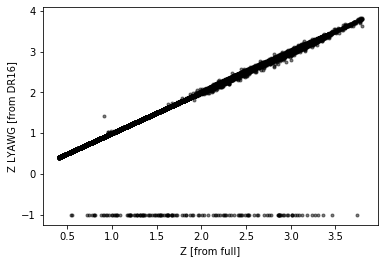

In [ ]:
spherematch

In [4]:
spherematch?

In [9]:
for n in dr16.dtype.names:
    if 'ID' in n:
        print(n) 

FIBERID
THING_ID
OBJID
FIBERID_DUPLICATE
ID_NUMBER
UKIDSS_MATCHED
2RXS_ID
XMM_SRC_ID


In [11]:
for n in fullngc.dtype.names:
    if 'ID' in n:
        print(n)

ID
EBOSS_TARGET_ID
THING_ID
OBJID_TARGETING
OBJID_DECALS
LOCATIONID
IDUPLICATE
QSO_ID
FIBERID
OBJID
ID_NUMBER


In [14]:
np.unique(fullngc['OBJID'])

array(['', '1197132292200071475', '1237651065191268656', ...,
       '1237674474365714731', '1237674474365714982',
       '1237674474365780807'], dtype='<U19')

In [18]:
fullngc['EBOSS_TARGET_ID'].min()

89900005

In [19]:
def cut(fullngc):
    m = fullngc['COMP_BOSS'] > 0.5
    m &= fullngc['sector_SSR'] > 0.5
    return fullngc[m]

In [20]:
sample = cut(fullngc)

In [21]:
sample.size

340027

In [22]:
sample['OBJID'], dr16['OBJID']

(array(['', '', '', ..., '', '', ''], dtype='<U19'),
 array(['1237666185111273711', '1237663234451309152',
        '1237669517441827491', ..., '1237678598090457176',
        '1237680247351279916', '1237663235523477803'], dtype='<U19'))

In [17]:
fullngc['THING_ID'].min()

252493675

In [5]:
dr16[1].read()

OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/B/Shared/mehdi/eboss/data/v7_2/DR16Q_v3.fits


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

[ 000002.99 ]   0: 03-21 22:02  EbossCatalog    INFO     compmin : 0.5
[ 000002.99 ]   0: 03-21 22:02  EbossCatalog    INFO     zmin:0.8, zmax:3.5
[ 000003.04 ]   0: 03-21 22:02  EbossCatalog    INFO     151487 galaxies pass the cuts
[ 000003.05 ]   0: 03-21 22:02  EbossCatalog    INFO     % of galaxies after cut 0.60
[ 000005.05 ]   0: 03-21 22:02  EbossCatalog    INFO     compmin : 0.5
[ 000005.05 ]   0: 03-21 22:02  EbossCatalog    INFO     zmin:0.8, zmax:3.5
[ 000005.57 ]   0: 03-21 22:02  EbossCatalog    INFO     8658242 randoms pass the cuts
[ 000005.58 ]   0: 03-21 22:02  EbossCatalog    INFO     % of randoms after cut 0.72
[ 000008.22 ]   0: 03-21 22:02  numexpr.utils   INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[ 000008.22 ]   0: 03-21 22:02  numexpr.utils   INFO     NumExpr defaulting to 8 threads.


[ 000013.72 ]   0: 03-21 22:02  SystematicsPrepare INFO     available columns : Index(['nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g',
       'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z',
       'w1_med', 'w1_covmed', 'w1_moon', 'star_density', 'loghi', 'run',
       'depth_g_minus_ebv'],
      dtype='object')


In [7]:
rm /B/Shared/mehdi/eboss/test/*

[ 000022.10 ]   0: 03-21 22:02  SystematicsPrepare INFO     split based on [0.8, 1.5]
[ 000022.10 ]   0: 03-21 22:02  EbossCatalog    INFO     Grab a slice with [0.8, 1.5]
[ 000022.10 ]   0: 03-21 22:02  EbossCatalog    INFO     # of data that pass this cut 60740
[ 000022.72 ]   0: 03-21 22:02  EbossCatalog    INFO     Projecting to HEALPIX as galaxy with 512
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)
[ 000022.83 ]   0: 03-21 22:02  EbossCatalog    INFO     Grab a slice with [0.8, 2.2]
[ 000022.87 ]   0: 03-21 22:02  EbossCatalog    INFO     # of data that pass this cut 7169801
[ 000023.85 ]   0: 03-21 22:02  EbossCatalog    INFO     Projecting to HEALPIX as random with 512
[ 000025.95 ]   0: 03-21 22:02  SystematicsPrepare INFO     df shape : (155801, 23)
[ 000025.95 ]   0: 03-21 22:02  SystematicsPrepare INFO     columns  : ['depth_g_

In [18]:
fracmin = 0.0
fracmask = randoms.hpmap > fracmin

nnbar = overdensity(data.hpmap, randoms.hpmap, fracmask) + 1

In [27]:
dataframe['ngal'] = nnbar

In [25]:
from LSSutils.stats.pcc import PCC, BTPCC

In [26]:
help(PCC)

Help on function PCC in module LSSutils.stats.pcc:

PCC(xc, yc, kind='spearman')



In [37]:
df = dataframe.dropna().to_numpy()

In [38]:
dfcorr = PCC(df[:, :-1], df[:, -1])

In [39]:
dfcorr

[-0.002002414335091633,
 -0.002895251481864315,
 -0.005589415349807417,
 -0.006016946780097513,
 0.0015849554539790654,
 -0.0017222473479968224,
 -0.0016588475637697633,
 -0.0012516341654975273,
 -0.004755755996959896,
 -0.003221748111257171,
 -0.0003692390018023999,
 0.0007215015828936875,
 0.0003518893940612726,
 -0.0018702942592474046,
 0.0003776602223715997,
 0.00022188537440931226,
 -0.0022316557548663165,
 -0.0003591689055091493,
 -0.00037452299649997386,
 0.0017797057167188283]

In [41]:
dfcorr_bs = BTPCC(df[:, :-1], df[:, -1])

In [45]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.1, 0.9, '')

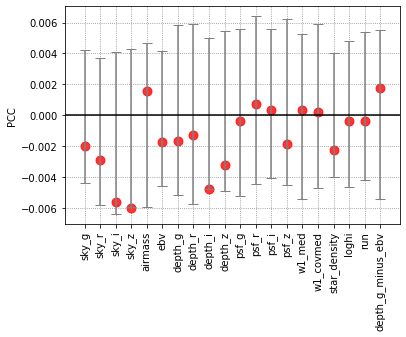

In [49]:
title = ''
fig, ax = plt.subplots()

x = np.arange(len(dfcorr))
prcntiles = np.percentile(dfcorr_bs, [0.5, 99.5], axis=0)

#ax.bar(x, self.pcc, color='crimson', alpha=0.5)
#ax.fill_between(x, y1=prcntiles[0], y2=prcntiles[1], alpha=0.2, color='b')
ax.errorbar(x, np.zeros_like(x), 
        yerr=[-prcntiles[0], prcntiles[1]], 
        alpha=1., color='grey',
        ls='None', capsize=5)

ax.scatter(x, dfcorr, 80, color='red',
       alpha=0.8, marker='o')

ax.set_xticks(x)
ax.grid(True, ls=':', color='grey')
ax.set_xticklabels(dataframe.columns[:-1], rotation=90)
ax.set(ylabel='PCC')
ax.axhline(0, color='k')
ax.text(0.1, 0.9, title, transform=ax.transAxes)



In [31]:
help(df.corr)

Help on method corr in module pandas.core.frame:

corr(method='pearson', min_periods=1) method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values.
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'} or callable
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
        * callable: callable with input two 1d ndarrays
            and returning a float. Note that the returned matrix from corr
            will have 1 along the diagonals and will be symmetric
            regardless of the callable's behavior
            .. versionadded:: 0.24.0
    
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid result. Currently only available for Pearson
        and Spearman correlation.
    
    Returns
    -------
    DataFrame
        

In [12]:
dataframe.to_numpy()

array([[ 0.        ,         nan,         nan, ..., 20.80267964,
                nan,         nan],
       [ 0.        ,         nan,         nan, ..., 20.78757448,
                nan,         nan],
       [ 0.        ,         nan,         nan, ..., 20.77638564,
                nan,         nan],
       ...,
       [ 0.        ,         nan,         nan, ..., 20.97504956,
                nan,         nan],
       [ 0.        ,         nan,         nan, ..., 20.95873424,
                nan,         nan],
       [ 0.        ,         nan,         nan, ..., 21.00141075,
                nan,         nan]])

In [ ]:
mv /home/mehdi/data/eboss/sysmaps/S

In [4]:
help(lab.catalogs.combinefits.EbossCatalog)

Help on class EbossCatalog in module LSSutils.catalogs.combinefits:

class EbossCatalog(builtins.object)
 |  EbossCatalog(filename, kind='galaxy', **kwargs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, kind='galaxy', **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cutz(self, zlim)
 |  
 |  make_plots(self, zcuts, filename='wsystot_test.pdf', zlim=[0.8, 3.6], slices=['low', 'high', 'zhigh'])
 |  
 |  plot_nzratio(self, zlim=[0.8, 3.6])
 |  
 |  plot_wsys(self, zcuts, slices=['low', 'high', 'zhigh'])
 |  
 |  prepare_weight(self)
 |  
 |  select(self, compmin=0.5, zmin=0.8, zmax=2.2)
 |      `Full` to `Clustering` Catalog
 |  
 |  swap(self, zcuts, slices, colname='WEIGHT_SYSTOT', clip=False)
 |  
 |  to_fits(self, filename)
 |  
 |  tohp(self, nside)
 |  
 |  writehp(self, filename, overwrite=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dic

In [ ]:
#!/usr/bin/env python
'''
    Update
    jan 03, switch back to v7_1
    dec 14, switch to 512
'''
import numpy as np
import pandas as pd
import logging
import os

import sys
sys.path.append('/home/mehdi/github/LSSutils')
from LSSutils import setup_logging
from LSSutils.catalogs.combinefits import EbossCatalog, hd5_2_fits
#from LSSutils.catalogs.datarelease import cols_eboss_v6_qso_simp as my_cols
from LSSutils.catalogs.datarelease import cols_eboss_mocks_qso as my_cols


setup_logging("info")


from argparse import ArgumentParser
ap = ArgumentParser(description='PREPARE EBOSS DATA FOR NN REGRESSION')
ap.add_argument('--nside',  type=int, default=512)
ap.add_argument('--cap',    type=str, default='NGC')
ap.add_argument('--target', type=str, default='QSO')
ap.add_argument('--slices', type=str, default=['low', 'high', 'all', 'zhigh', 'z1','z2', 'z3'], nargs='*')

ns = ap.parse_args()    

## --- input parameters
nside  = ns.nside
cap    = ns.cap
target = ns.target
slices = ns.slices

## --- z-cuts --- 
#zcuts     = {'0.8': [0.80, 1.14],
#             '1.1': [1.14, 1.39],
#             '1.4': [1.39, 1.63],
#             '1.6': [1.63, 1.88],
#             '1.9': [1.88, 2.20]}

#zcuts = {'all':[0.80, 2.20]}

#zcuts = {'low':[0.80, 1.50],
#        'high':[1.50, 2.20]}

zcuts = {'low':[0.8, 1.5],
         'high':[1.5, 2.2],
         'all':[0.8, 2.2],
         'zhigh':[2.2, 3.5],
         'z1':[0.8, 1.3],
         'z2':[1.3, 1.6],
         'z3':[1.6, 2.2]}


output_dir    = '/home/mehdi/data/eboss/v7_2/0.1'    
data_name_in = f'/home/mehdi/data/eboss/v7_2/eBOSS_{target}_full_{cap}_v7_2.dat.fits'
rand_name_in = f'/home/mehdi/data/eboss/v7_2/eBOSS_{target}_full_{cap}_v7_2.ran.fits'

#--- logger
# logging.basicConfig(
#     #filename=output_dir + '/test.log',
#     level=logging.INFO,
#     format="%(asctime)s:%(levelname)s:%(message)s"
#     )
logger = logging.getLogger("Logger 1")

# --- check if the output directory exists
if not os.path.isdir(output_dir):
    logger.info('create {}'.format(output_dir))
    os.makedirs(output_dir)
logger.info('results will be written under {}'.format(output_dir))    

# --- input files
logger.info('prepare the files for NN regression ')
logger.info('read {}'.format(data_name_in))
logger.info('read {}'.format(rand_name_in))

# --- imaging templates
systematics_dir  = '/home/mehdi/data/eboss/sysmaps'
systematics_name = systematics_dir + '/SDSS_WISE_HI_imageprop_nside512.h5'
dataframe = pd.read_hdf(systematics_name, key='templates')
logger.info('read {}'.format(systematics_name))

for i, key_i in enumerate(slices):
    
    if key_i not in slices:
         raise RuntimeError(f'{key_i} not in {slices}')

    logger.info('split based on {}'.format(zcuts[key_i]))

    #--- read galaxy and random 
    if key_i=='zhigh':
        zmin = 2.2
        zmax = 3.5
    else:
        zmin=0.8
        zmax=2.2

    mock   = EbossCatalog(data_name_in, 'galaxy', zmin=zmin, zmax=zmax)
    random = EbossCatalog(rand_name_in, 'random', zmin=zmin, zmax=zmax)    


    # --- prepare the names for the output files
    hpcat     = output_dir + f'/galmap_{cap}_{key_i}_{nside}.hp.fits'
    hpmask    = output_dir + f'/mask_{cap}_{key_i}_{nside}.hp.fits'
    fracgood  = output_dir + f'/frac_{cap}_{key_i}_{nside}.hp.fits'
    fitname   = output_dir + f'/ngal_features_{cap}_{key_i}_{nside}.fits'    
    fitkfold  = output_dir + f'/ngal_features_{cap}_{key_i}_{nside}.5r.npy'

    mock.cutz(zcuts[key_i])
    mock.tohp(nside)
    mock.writehp(hpcat)    
    
    ##random.apply_zcut(zcuts[key_i]) ## -- we don't cut randoms
    ##random.cutz([0.8, 2.2])
    random.tohp(nside)
    
    # --- append the galaxy and random density
    dataframe_i = dataframe.copy()
    dataframe_i['ngal'] = mock.hpmap
    dataframe_i['nran'] = random.hpmap    
    dataframe_i['nran'][random.hpmap == 0] = np.nan
    
    dataframe_i.dropna(inplace=True)
    logger.info('df shape : {}'.format(dataframe_i.shape))
    logger.info('columns  : {}'.format(my_cols))
    
    # --- write 
    hd5_2_fits(dataframe_i, 
                  my_cols, 
                  fitname, 
                  hpmask, 
                  fracgood, 
                  fitkfold,
                  res=nside, 
                  k=5)